<a href="https://colab.research.google.com/github/cap-vparekh/DataScience/blob/DEV/Copy_of_K_Means_Clustering_%E2%80%93_Movie_Ratings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Business Context & Objectives
Imagine you work for a movie-streaming platform (like Netflix, Prime Video, or a niche indie service). You have a large “ratings” table showing which user gave which score (1–5) to which movie. Your goal is to help the content/marketing team identify:

 * Blockbusters (many ratings, high average score)
 * Hidden Gems (fewer ratings, but very high scores)
 * Crowd-Pleasers vs. Flops (many ratings, lower scores)
 * Undiscovered Low-Interest Movies (few ratings, low scores)

By clustering “(number of ratings, average rating)”, you can automatically group movies into meaningful buckets—so that:
 * The marketing team can feature “Hidden Gems” on the homepage to help them get discovered.
 * The content acquisition team can invest more in movies trending toward “blockbuster” status.
 * The editorial team can spot early‐stage “underperformers” before they long‐tail on the platform.



##Dataset Overview

We’ll use the MovieLens 100k dataset (from GroupLens Research), freely available here:
https://grouplens.org/datasets/movielens/100k/

Key files:
1. u.data (ratings file)
 * Columns: user_id, movie_id, rating (1–5), timestamp
 * 100,000 ratings from ~943 users on 1,682 movies.

2. u.item (movie metadata)
 * Columns: movie_id, movie_title, (plus genre flags we won’t need right now)

For our clustering, we only need u.data, because we’ll derive:
* num_ratings per movie (i.e., how many users rated it)
* avg_rating per movie (the mean of all ratings)

Then we'll cluster on those two numbers.



##Why K-Means on Movie Ratings?
* Intuition: Movies with many ratings and high average likely reflect a broad audience liking them—these are “Blockbusters.”
* Movies with few ratings but high average are “Hidden Gems” (critically acclaimed but niche).
* Conversely, many ratings but low average = “Massive but disliked” (over-tested flops), and few ratings + low average = “Obscure Underperformers.”
* K-Means will partition the 1,682 movies into k groups so that average WCSS (within‐cluster distance) is minimized. Each cluster’s centroid will tell us, “This cluster represents, e.g., movies with ~1,000 ratings averaging ~4.5 stars.”



In [ ]:
# 1) Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# For inline plots (if using Jupyter/Colab)
%matplotlib inline


In [ ]:
# 2) Load the “u.data” file
# (Assume we’ve downloaded 'u.data' into the same folder as our notebook)
column_names = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings_df = pd.read_csv('/home/u.data', sep='\t', names=column_names, encoding='latin-1') #https://grouplens.org/datasets/movielens/100k/

# Peek at the first 5 rows
print(ratings_df.head())

'''
Our ratings_df table has 100,000 rows. Each row is one rating by a user for a movie. We have:
• user_id (e.g., 196)
• movie_id (e.g., 242)
• rating (1–5)
• timestamp (we won’t use timestamps)
'''

   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596


'\nOur ratings_df table has 100,000 rows. Each row is one rating by a user for a movie. We have:\n• user_id (e.g., 196)\n• movie_id (e.g., 242)\n• rating (1–5)\n• timestamp (we won’t use timestamps)\n'

In [ ]:
# 3) Quick sanity check: total unique movies and users
num_movies = ratings_df['movie_id'].nunique()
num_users  = ratings_df['user_id'].nunique()
print(f"Number of unique movies: {num_movies}")
print(f"Number of unique users : {num_users}")

#We have 1,682 distinct movies rated by 943 users.

Number of unique movies: 1682
Number of unique users : 943


In [ ]:
# 4) Group by movie_id to compute:
#    - num_ratings (count of rows per movie_id)
#    - avg_rating (mean of ratings per movie_id)

movie_stats = ratings_df.groupby('movie_id')['rating'].agg(
    num_ratings = 'count',
    avg_rating  = 'mean'
).reset_index()

# Peek at the result
movie_stats.head()

#For each movie_id, count how many ratings it has (num_ratings) and compute the mean rating (avg_rating).

,movie_id,num_ratings,avg_rating
0,1,452,3.878319
1,2,131,3.206107
2,3,90,3.033333
3,4,209,3.550239
4,5,86,3.302326


In [ ]:
# 5) Check the shape and some stats
print("Shape of movie_stats:", movie_stats.shape)
movie_stats.describe().round(2)

'''
(1682, 3) -> 1 column for movie_id, 1 for num_ratings, 1 for avg_rating.


 6) (Optional) Filter out extremely low-rated/low-rated-count movies
     For this demo, let’s keep all movies—even those with 1 rating.
     But in a real platform, you might only trust movies with > 10 ratings.
'''
movie_stats = movie_stats[movie_stats['num_ratings'] > 10]
print("Shape of movie_stats:", movie_stats.shape)
'''
Why filter?
A movie with only 1 rating is noisy; if that 1 user gave 5 stars, it skews avg_rating.
In practice, you’d require a minimum “num_ratings” (like 10 or 20) for reliability.
For our demo, we’ll keep all movies—so you can see what “ultra-niche” looks like.
'''



Shape of movie_stats: (1682, 3)
Shape of movie_stats: (1119, 3)


'\nWhy filter?\nA movie with only 1 rating is noisy; if that 1 user gave 5 stars, it skews avg_rating.\nIn practice, you’d require a minimum “num_ratings” (like 10 or 20) for reliability.\nFor our demo, we’ll keep all movies—so you can see what “ultra-niche” looks like.\n'

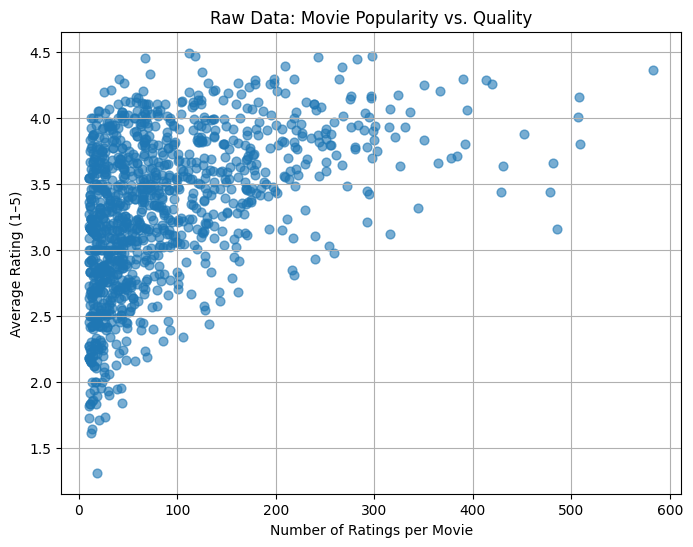

'\nOn the x-axis: how many times each movie was rated.\nOn the y-axis: the average rating (1–5).\nYou’ll likely see a cluster of movies with very few ratings scattered \nat all rating levels, and a dense cloud of moderately‐rated (avg ~3–4) with many ratings.\n'

In [ ]:
# 7) Quick scatterplot: num_ratings vs. avg_rating
plt.figure(figsize=(8, 6))
plt.scatter(movie_stats['num_ratings'], movie_stats['avg_rating'], alpha=0.6, s=40)
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Average Rating (1–5)')
plt.title('Raw Data: Movie Popularity vs. Quality')
plt.grid(True)
plt.show()

'''
On the x-axis: how many times each movie was rated.
On the y-axis: the average rating (1–5).
You’ll likely see a cluster of movies with very few ratings scattered
at all rating levels, and a dense cloud of moderately‐rated (avg ~3–4) with many ratings.
'''

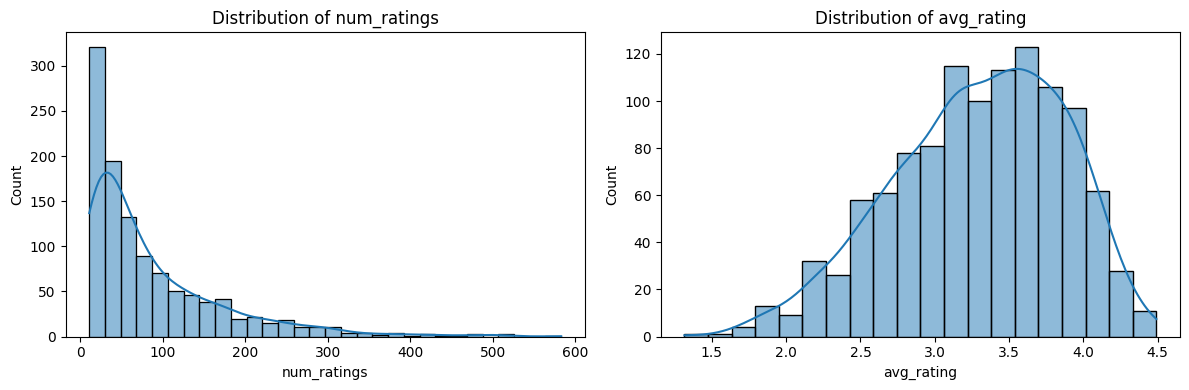

'\nnum_ratings is highly skewed (many movies have very few ratings; a few have hundreds).\navg_rating hovers around 3–4 for most movies, with fewer at the extremes.\n'

In [ ]:
# 8) Plot histograms of each feature separately
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(movie_stats['num_ratings'], bins=30, kde=True)
plt.title('Distribution of num_ratings')

plt.subplot(1, 2, 2)
sns.histplot(movie_stats['avg_rating'], bins=20, kde=True)
plt.title('Distribution of avg_rating')

plt.tight_layout()
plt.show()
'''
num_ratings is highly skewed (many movies have very few ratings; a few have hundreds).
avg_rating hovers around 3–4 for most movies, with fewer at the extremes.
'''

In [ ]:
# 9) Extract the two columns into X for clustering
X = movie_stats[['num_ratings', 'avg_rating']].values

# 10) Scale X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

'''
Why Scale?
K-Means uses Euclidean distance.
If num_ratings ranges from 1 to 600 but avg_rating ranges only 1–5, then num_ratings will dominate the clustering.
Solution: Bring both features to the same scale (mean=0, variance=1) using StandardScaler.
'''

'\nWhy Scale?\nK-Means uses Euclidean distance.\nIf num_ratings ranges from 1 to 600 but avg_rating ranges only 1–5, then num_ratings will dominate the clustering.\nSolution: Bring both features to the same scale (mean=0, variance=1) using StandardScaler.\n'

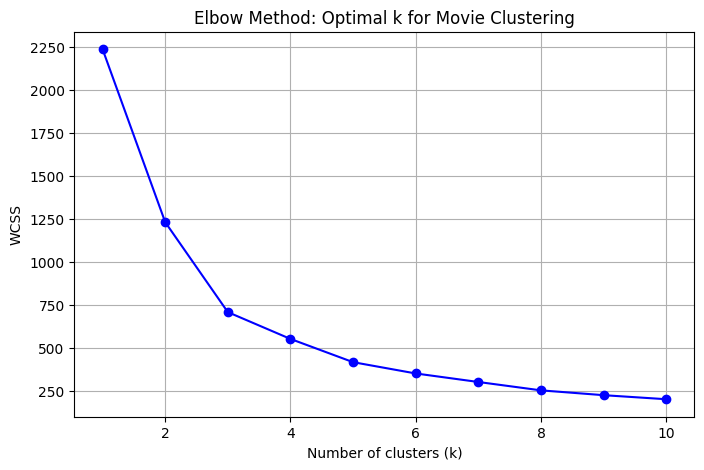

k = 1 	 WCSS = 2238.0
k = 2 	 WCSS = 1231.9
k = 3 	 WCSS = 708.8
k = 4 	 WCSS = 552.8
k = 5 	 WCSS = 417.6
k = 6 	 WCSS = 352.0
k = 7 	 WCSS = 302.4
k = 8 	 WCSS = 253.7
k = 9 	 WCSS = 225.7
k = 10 	 WCSS = 202.1


'\nIf the elbow is at k=4, that suggests 4 clusters best balance “compactness” vs. “simplicity.”\nSometimes it’s not perfectly clear—use business sense.\nFor our demo, we’ll pick k = 4.\n'

In [ ]:
#Find Optimal k via Elbow Method
# 12) Compute WCSS for k = 1..10
wcss = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# 13) Plot the Elbow graph
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, 'bo-', markersize=6)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method: Optimal k for Movie Clustering')
plt.grid(True)
plt.show()


# (Optional) Print WCSS values to inspect numeric elbow
for i, val in zip(K_range, wcss):
    print(f"k = {i} \t WCSS = {val:.1f}")

'''
If the elbow is at k=4, that suggests 4 clusters best balance “compactness” vs. “simplicity.”
Sometimes it’s not perfectly clear—use business sense.
For our demo, we’ll pick k = 4.
'''

In [ ]:
# 14) Run final KMeans with k = 4
k_optimal = 4
kmeans_final = KMeans(n_clusters=k_optimal, init='k-means++', random_state=42)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# 15) Add cluster labels back to our movie_stats DataFrame
movie_stats['Cluster'] = cluster_labels

# 16) Inspect how many movies per cluster
print(movie_stats['Cluster'].value_counts().sort_index())

'''
Display the value counts as a little bar chart or print list.
E.g., Cluster 0: 450 movies, Cluster 1: 550 movies, Cluster 2: 300 movies, Cluster 3: 382 movies
'''

Cluster
0    224
1    366
2     76
3    453
Name: count, dtype: int64


'\nDisplay the value counts as a little bar chart or print list.\nE.g., Cluster 0: 450 movies, Cluster 1: 550 movies, Cluster 2: 300 movies, Cluster 3: 382 movies\n'

In [ ]:
# 17) View cluster centroids in scaled space
centroids_scaled = kmeans_final.cluster_centers_

# 18) Transform centroids back to original “num_ratings” & “avg_rating”
centroids_original = scaler.inverse_transform(centroids_scaled)
centroid_df = pd.DataFrame(centroids_original, columns=['num_ratings', 'avg_rating'])
centroid_df['Cluster'] = range(k_optimal)
print(centroid_df)

'''
centroids_scaled gives the cluster centers in scaled units (where mean=0, std=1).
We inverse_transform to see them in original units (number of ratings, average rating).
Each row in centroid_df tells us: “Cluster 0 has center
 at (num_ratings≈ X₀, avg_rating≈ Y₀), Cluster 1 at (X₁, Y₁), …”
'''


   num_ratings  avg_rating  Cluster
0   160.977679    3.662632        0
1    39.331507    2.625913        1
2   321.631579    3.891318        2
3    50.140969    3.544587        3


'\ncentroids_scaled gives the cluster centers in scaled units (where mean=0, std=1).\nWe inverse_transform to see them in original units (number of ratings, average rating).\nEach row in centroid_df tells us: “Cluster 0 has center\n at (num_ratings≈ X₀, avg_rating≈ Y₀), Cluster 1 at (X₁, Y₁), …”\n'

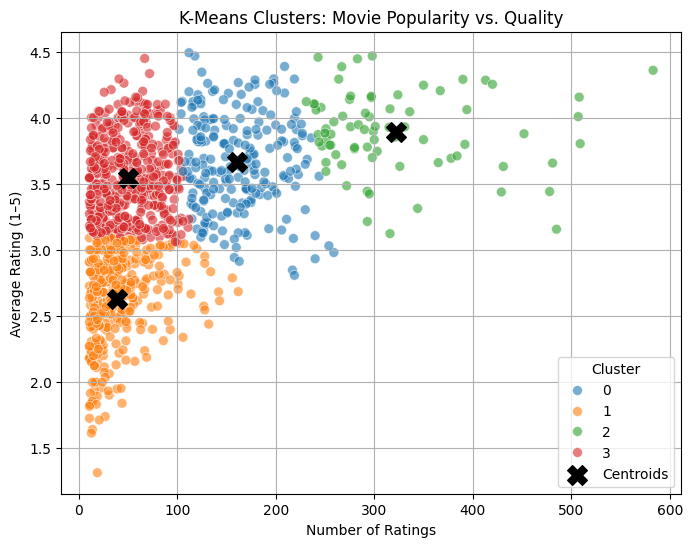

In [ ]:
# 19) Scatter plot: movies colored by cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=movie_stats,
    x='num_ratings',
    y='avg_rating',
    hue='Cluster',
    palette='tab10',
    alpha=0.6,
    s=50
)

# Plot centroids as big black X’s
plt.scatter(
    centroid_df['num_ratings'],
    centroid_df['avg_rating'],
    s=200,
    c='black',
    marker='X',
    label='Centroids'
)

plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating (1–5)')
plt.title('K-Means Clusters: Movie Popularity vs. Quality')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


1. Blockbusters (Cluster 2):
 * Far to the right (many ratings) and high on y-axis (avg_rating ~4).
 * Centroid might be at (num_ratings≈400, avg_rating≈4.2).

2. Hidden Gems (Cluster 3):
 * Left side (few ratings), but high y-axis (avg_rating ~4.5).
 * Centroid at (num_ratings≈20, avg_rating≈4.3).

3. Flops (Cluster 1):
 * Right side (many ratings), but lower y-axis (avg_rating ~2.5).
 * Centroid at (num_ratings≈300, avg_rating≈2.8).

4. Obscure Underdogs (Cluster 0):
 * Left (few ratings) and low y-axis (avg_rating ~2).
 * Centroid at (num_ratings≈10, avg_rating≈2.1).



##Summary
* Selecting Features
* Scaling Matters
* Elbow Method Intuition
* Interpreting Clusters
* Visualization
* Action-Oriented Insights